In [1]:
# IMPORTS

import os
import env

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from math import sqrt
from scipy import stats

# import our my acquire module
import acquire
import prepare


# import splitting, imputing and modelling functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from prepare import my_train_test_split, telco_training_validate_testing

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

In [2]:
# obtaining the prepared Telco dataset.

telco_df = acquire.get_telco_data(env.sql_connexion)
tidy_telco = prepare.prep_telco(telco_df)

In [3]:
tidy_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   gender                 7043 non-null   object 
 2   senior_citizen         7043 non-null   int64  
 3   partner                7043 non-null   object 
 4   dependents             7043 non-null   object 
 5   tenure                 7043 non-null   int64  
 6   phone_service          7043 non-null   object 
 7   multiple_lines         7043 non-null   object 
 8   online_security        7043 non-null   object 
 9   online_backup          7043 non-null   object 
 10  device_protection      7043 non-null   object 
 11  tech_support           7043 non-null   object 
 12  streaming_tv           7043 non-null   object 
 13  streaming_movies       7043 non-null   object 
 14  paperless_billing      7043 non-null   object 
 15  mont

In [4]:
#dropping any possible nulls

tidy_telco = tidy_telco.dropna()

In [5]:
# creating dummies in order to help machine learning and modelling

dummies = pd.get_dummies(tidy_telco[['tech_support', 'internet_service_type']], drop_first = True)

dummies

,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,0,1,0,0
1,0,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,1,1,0
...,...,...,...,...
7038,0,1,0,0
7039,0,0,1,0
7040,0,0,0,0
7041,0,1,0,0


In [6]:
# concatenating dummies to the tidy_telco dataframe

tidy_telco = pd.concat([tidy_telco, dummies], axis = 1)
tidy_telco.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,dependents_No,dependents_Yes,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,0,1,0,1,1,0,0,1,0,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,1,0,1,0,1,0,0,0,0,0
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,1,0,0,1,0,1,0,0,1,0
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,1,0,0,1,0,1,0,0,1,0
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,1,0,0,1,0,1,0,1,1,0


In [7]:
# dropping columns unnecessary for modelling (namely, objects and columns with dummies created for them)

drop_columns = ['customer_id', 'gender', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines',
               'online_security', 'online_backup', 'device_protection', 'streaming_tv','streaming_movies', 
                'total_charges', 'gender_Female', 'gender_Male', 'partner_No', 'partner_Yes', 'dependents_No',
                'dependents_Yes', 'payment_type', 'contract_type', 'churn', 'paperless_billing', 'tech_support', 
               'internet_service_type']

In [8]:
# dropping columns for machine learning purposes

tidy_telco.drop(columns = drop_columns, inplace = True)

tidy_telco.head()

,senior_citizen,monthly_charges,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,0,65.6,0,1,1,0,0,1,0,0
1,0,59.9,1,0,1,0,0,0,0,0
2,0,73.9,0,1,0,1,0,0,1,0
3,1,98.0,0,1,0,1,0,0,1,0
4,1,83.9,0,1,0,1,0,1,1,0


In [9]:
# checking values in tidy_telco

tidy_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   senior_citizen                     7043 non-null   int64  
 1   monthly_charges                    7043 non-null   float64
 2   paperless_billing_No               7043 non-null   uint8  
 3   paperless_billing_Yes              7043 non-null   uint8  
 4   churn_No                           7043 non-null   uint8  
 5   churn_Yes                          7043 non-null   uint8  
 6   tech_support_No internet service   7043 non-null   uint8  
 7   tech_support_Yes                   7043 non-null   uint8  
 8   internet_service_type_Fiber optic  7043 non-null   uint8  
 9   internet_service_type_None         7043 non-null   uint8  
dtypes: float64(1), int64(1), uint8(8)
memory usage: 165.2 KB


In [10]:
# splitting into train-validate-test


train, validate, test = my_train_test_split(tidy_telco, target = 'churn_No')

train.shape, validate.shape, test.shape


((4225, 10), (1409, 10), (1409, 10))

In [11]:
# # baseline for churn is no-churn (ie, ['churn_No'] == '1').

train[train.churn_No == 1]

# churn_Yes = 0. // 0 = False, thus, if churn_Yes is False, then the customer has not churned
# if churn_Yes = 1, then churn_Yes is true, and the customer has churned

,senior_citizen,monthly_charges,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
3441,0,92.15,0,1,1,0,0,0,1,0
1266,0,79.80,0,1,1,0,0,0,1,0
5086,0,62.25,1,0,1,0,0,1,0,0
5279,1,60.25,1,0,1,0,0,0,0,0
134,0,84.30,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2791,0,19.20,0,1,1,0,1,0,0,1
6776,0,20.55,1,0,1,0,1,0,0,1
141,0,45.00,1,0,1,0,0,0,0,0
5053,1,60.70,1,0,1,0,0,0,0,0


In [12]:
baseline = (train.churn_No == 1).mean()
baseline
# how many customers did not churn
# my baseline is abotu 73.46pc

0.7346745562130178

In [13]:
# comparing the 'churn' and 'churn_No' columns

train.churn_No.value_counts()

# 1 = True (ie, no-churned).

1    3104
0    1121
Name: churn_No, dtype: int64

In [14]:
## split train, val, test from above into X_train, X_val, X_test and y-train, etc
# y_train is only our target
# X_ is everything except for 'churn_Yes' and 'churn_No'


X_train = train.drop(columns = ['churn_Yes', 'churn_No'])
y_train = train['churn_No']

X_val = validate.drop(columns = ['churn_Yes', 'churn_No'])
y_val = validate['churn_No']

X_test = test.drop(columns = ['churn_Yes', 'churn_No'])
y_test = test['churn_No']

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 3441 to 6996
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   senior_citizen                     4225 non-null   int64  
 1   monthly_charges                    4225 non-null   float64
 2   paperless_billing_No               4225 non-null   uint8  
 3   paperless_billing_Yes              4225 non-null   uint8  
 4   tech_support_No internet service   4225 non-null   uint8  
 5   tech_support_Yes                   4225 non-null   uint8  
 6   internet_service_type_Fiber optic  4225 non-null   uint8  
 7   internet_service_type_None         4225 non-null   uint8  
dtypes: float64(1), int64(1), uint8(6)
memory usage: 123.8 KB


In [16]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 2742 to 3864
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   senior_citizen                     1409 non-null   int64  
 1   monthly_charges                    1409 non-null   float64
 2   paperless_billing_No               1409 non-null   uint8  
 3   paperless_billing_Yes              1409 non-null   uint8  
 4   tech_support_No internet service   1409 non-null   uint8  
 5   tech_support_Yes                   1409 non-null   uint8  
 6   internet_service_type_Fiber optic  1409 non-null   uint8  
 7   internet_service_type_None         1409 non-null   uint8  
dtypes: float64(1), int64(1), uint8(6)
memory usage: 41.3 KB


In [17]:
X_train.head()

,senior_citizen,monthly_charges,paperless_billing_No,paperless_billing_Yes,tech_support_No internet service,tech_support_Yes,internet_service_type_Fiber optic,internet_service_type_None
3441,0,92.15,0,1,0,0,1,0
289,0,20.90,1,0,1,0,0,1
1266,0,79.80,0,1,0,0,1,0
275,1,101.50,0,1,0,0,1,0
5086,0,62.25,1,0,0,1,0,0


### Modelling on the Decision Tree

In [18]:
# initialise the Decision Tree Classifier = clf

seed = 23

clf = DecisionTreeClassifier(max_depth = 3, random_state = seed)

In [19]:
# fitting the model : 
    # it must know the features and the labels, in order to associate them with one another.
    
# with this step, the model has been trained.

clf = clf.fit(X_train, y_train)
clf

DecisionTreeClassifier(max_depth=3, random_state=23)

In [20]:
# Examining accuracy of Decision Tree Classifier model :
# prediction on the X_train set against the y_train reality.


clf.score(X_train, y_train)

# the X_train data is compared against y_train : 75.03pc accuracy

0.7505325443786982

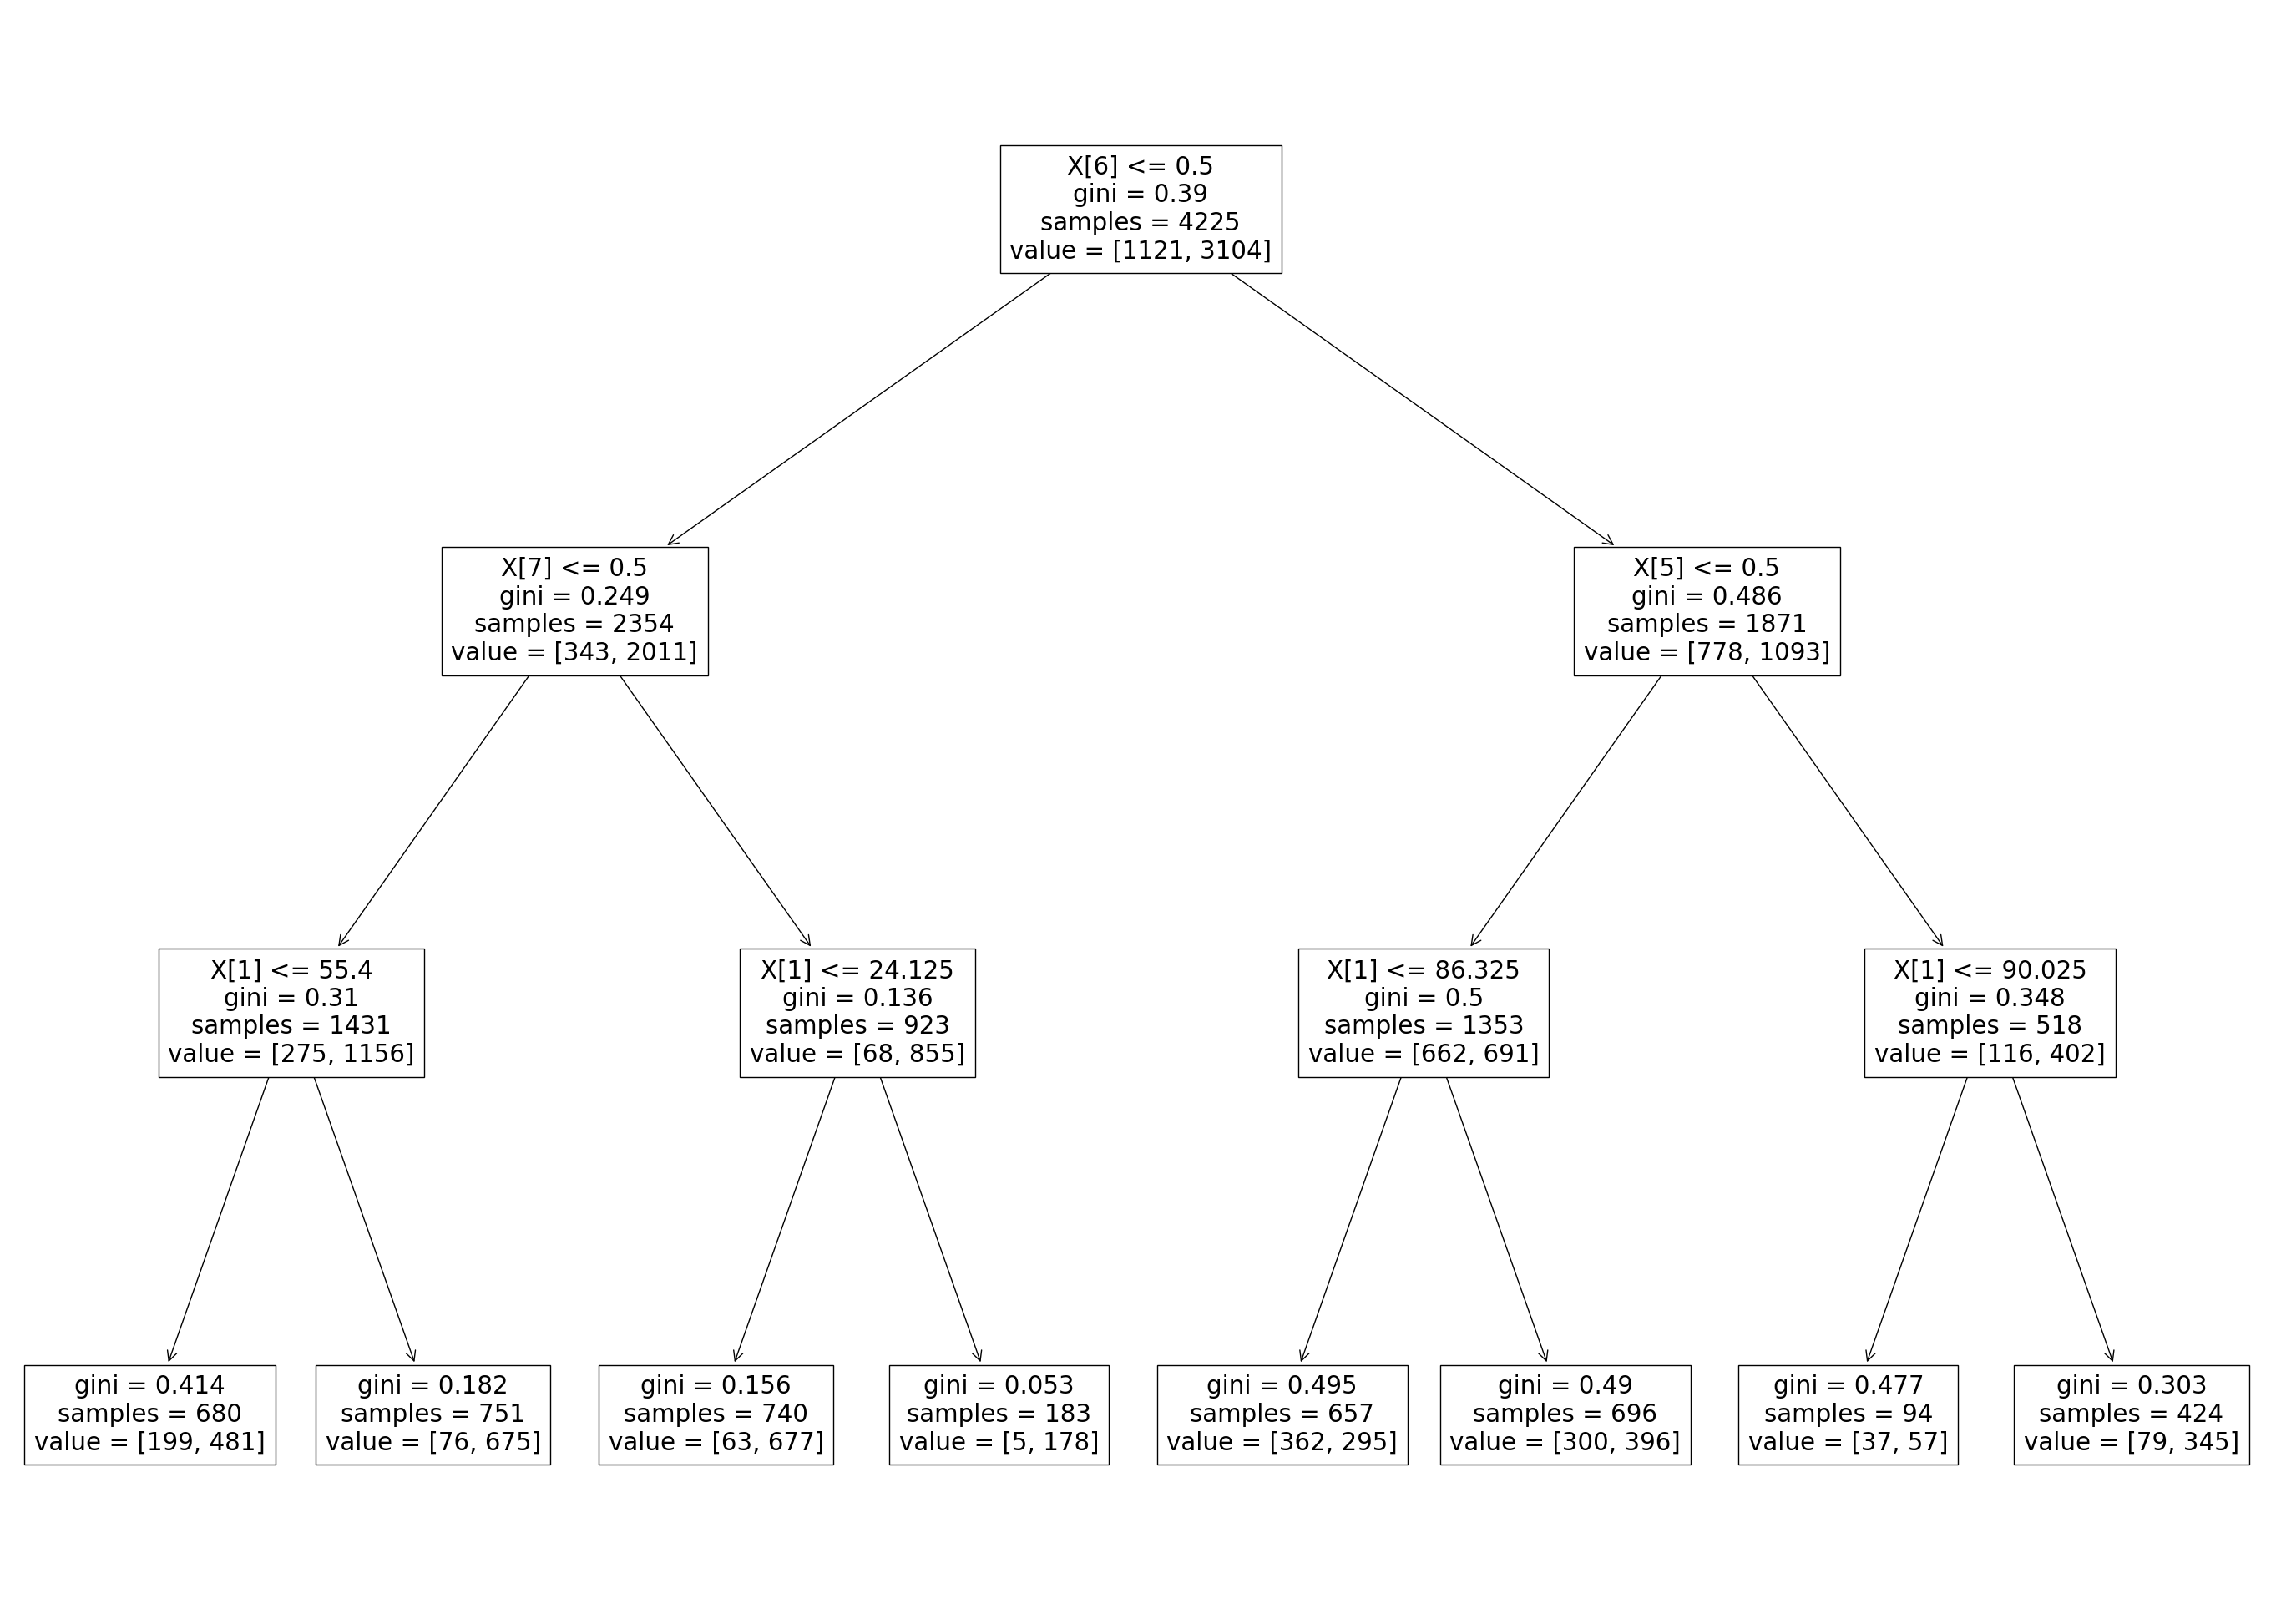

In [21]:
# plotting the Decision Tree 

plt.figure(figsize = (35, 25))

plot_tree(clf, rounded = False)

plt.show()


# max depth of 3 = three layers of decisions / splits being made in data

In [22]:
# predictions for churn are on the X_train ; true values are on y_train

y_train_predictions = clf.predict(X_train)

y_train_predictions[0:20]



array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=uint8)

In [23]:
# estimating the probability of churn for each customer based on X_train

y_predict_prob = clf.predict_proba(X_train)
y_predict_prob[0:20]

# each row adds up to 1 (F prob / T prob)

array([[0.43103448, 0.56896552],
       [0.08513514, 0.91486486],
       [0.55098935, 0.44901065],
       [0.43103448, 0.56896552],
       [0.1011984 , 0.8988016 ],
       [0.1011984 , 0.8988016 ],
       [0.55098935, 0.44901065],
       [0.29264706, 0.70735294],
       [0.1011984 , 0.8988016 ],
       [0.43103448, 0.56896552],
       [0.29264706, 0.70735294],
       [0.29264706, 0.70735294],
       [0.43103448, 0.56896552],
       [0.0273224 , 0.9726776 ],
       [0.1011984 , 0.8988016 ],
       [0.08513514, 0.91486486],
       [0.1011984 , 0.8988016 ],
       [0.29264706, 0.70735294],
       [0.43103448, 0.56896552],
       [0.1011984 , 0.8988016 ]])

In [24]:
## print the classification report :

print(f'Classification Report For Training Dataset \n  \n {classification_report(y_train, y_train_predictions)}')

# Accuracy of 75pc

Classification Report For Training Dataset 
  
               precision    recall  f1-score   support

           0       0.55      0.32      0.41      1121
           1       0.79      0.90      0.84      3104

    accuracy                           0.75      4225
   macro avg       0.67      0.61      0.62      4225
weighted avg       0.72      0.75      0.73      4225



In [25]:
# Turning the training accuracy score into a useable variable 

train_accuracy = clf.score(X_train, y_train)
train_accuracy

0.7505325443786982

In [26]:
# printing statment that makes sense to the general public :

print(f'The accuracy of the Decision Tree Classifier on the training dataset is{train_accuracy: .4f}.  \n'
      f'The baseline accuracy for customer churn is{baseline: .4f}, meaning that about\n' 
      '     73.47pc of customers will NOT churn.')

The accuracy of the Decision Tree Classifier on the training dataset is 0.7505.  
The baseline accuracy for customer churn is 0.7347, meaning that about
     73.47pc of customers will NOT churn.


In [27]:
# confusion matrix : A table of prediction vs actual

confusion_matrix(y_train, y_train_predictions)

array([[ 362,  759],
       [ 295, 2809]])

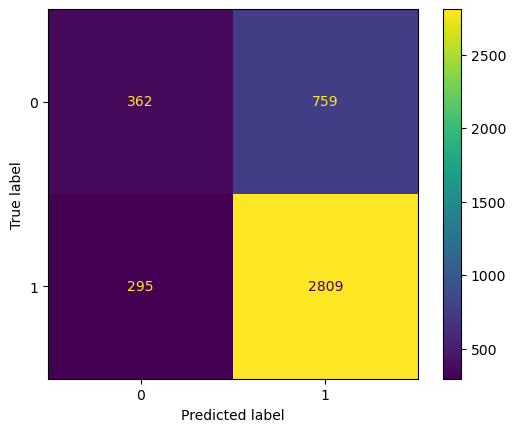

In [28]:
## plotting the confusion matrix of clf

plot_confusion_matrix(clf, X_train, y_train)

In [29]:
# code necessary for the confusion matrix function to function

y_preds = pd.DataFrame({
    'y_act': y_train,
    'baseline': 1,
    'model_1': clf.predict(X_train)
})


In [30]:
# assigning confusion matrix values to appropriate variables

TN, FP, FN, TP = confusion_matrix(y_preds.y_act, y_preds.model_1).ravel()

print(f'TN = {TN}, FP = {FP}, FN = {FN}, TP = {TP}')

TN = 362, FP = 759, FN = 295, TP = 2809


**The validation step, which folllows, of the Decision Tree Classifier authenticates the accuracy of the evaluation of the training dataset.**

In [31]:
#VALIDATION STEP

y_val_predictions = clf.predict(X_val)
y_val_predictions[0:20]

# predicted on X_Val, true values are on y_val

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
      dtype=uint8)

In [32]:
# estimating the probability of churn for each customer based on X_validate dataset

y_val_pred_prob = clf.predict_proba(X_val)
y_val_pred_prob[0:20]

# each row adds up to 1 (F prob / T prob)

array([[0.08513514, 0.91486486],
       [0.55098935, 0.44901065],
       [0.43103448, 0.56896552],
       [0.55098935, 0.44901065],
       [0.55098935, 0.44901065],
       [0.29264706, 0.70735294],
       [0.43103448, 0.56896552],
       [0.0273224 , 0.9726776 ],
       [0.29264706, 0.70735294],
       [0.0273224 , 0.9726776 ],
       [0.18632075, 0.81367925],
       [0.43103448, 0.56896552],
       [0.43103448, 0.56896552],
       [0.29264706, 0.70735294],
       [0.08513514, 0.91486486],
       [0.43103448, 0.56896552],
       [0.55098935, 0.44901065],
       [0.43103448, 0.56896552],
       [0.55098935, 0.44901065],
       [0.18632075, 0.81367925]])

In [33]:
## print the classification report :

print(f'Classification Report For Training Dataset \n  \n {classification_report(y_val, y_val_predictions)}')

# Accuracy of 75pc

Classification Report For Training Dataset 
  
               precision    recall  f1-score   support

           0       0.56      0.31      0.40       374
           1       0.78      0.91      0.84      1035

    accuracy                           0.75      1409
   macro avg       0.67      0.61      0.62      1409
weighted avg       0.73      0.75      0.73      1409



In [34]:
# Turning the training accuracy score into a useable variable 

val_accuracy = clf.score(X_val, y_val)
val_accuracy

0.752306600425834

In [35]:
# printing statment that makes sense to the general public :

print(f'The accuracy of the Decision Tree Classifier on the validation dataset is{val_accuracy: .4f}.  \n'
      f'The baseline accuracy for customer churn is{baseline: .4f}.')

The accuracy of the Decision Tree Classifier on the validation dataset is 0.7523.  
The baseline accuracy for customer churn is 0.7347.


**Takeaways :**   
The accuracy of the training dataset and the validation dataset was 75.05pc and 75.23pc, respectively.  
Both of these results are higher than the baseline accuracy for customer churn, with 73.47pc who would not churn.

### Modelling based on K-Nearest Neighbor

In [36]:
# creating the KNN variable for modelling
# looking to 15 neighbours

knn = KNeighborsClassifier(n_neighbors = 15)

In [37]:
# training the KNN model

knn.fit(X_train, y_train)



KNeighborsClassifier()

In [42]:
# scoring the model to determine how accurate the KNN model is. 

train_knn_score = knn.score(X_train, y_train)

# we're predicting on the features (X_train, the first variable), and
# comparing to the actual labels (the 2nd variable, y_train)

print(f'The accuracy of the training dataset using the KNN model is{train_knn_score: .4f}.')

The accuracy of the training dataset using the KNN model is 0.8104.


In [44]:
# examining the accuracy of the validation dataset 

val_knn_score = knn.score(X_val, y_val)

print(f'The accuracy of the validation dataset using the KNN model is{val_knn_score: .4f}.')

The accuracy of the validation dataset using the KNN model is 0.7296.
